In [1]:
import dataset_loader
import matplotlib.pyplot as plt
import midi
import numpy as np
import tqdm
import similarity
import util

In [2]:
DATASET_ROOT="../../sabana/dataset/asap-dataset"

SLICE_DURATION = 3 # sec
EXPANSION_RATE = 2.5
FRAME_PER_SECOND = 20 # Hz
SETTLING_FRAME = 6
COMPENSATION_FRAME = 0

In [ ]:
gen = dataset_loader.spawn(dataset_root=DATASET_ROOT, 
                           slice_duration=SLICE_DURATION,
                           expansion_rate=EXPANSION_RATE,
                           frame_per_second=FRAME_PER_SECOND,
                           shuffle=True)

In [ ]:
score, perf, (original_head, original_tail) = next(gen)
util.plot_midi_matrices(score, perf, (original_head, original_tail), title="Before decaying")

In [ ]:
decayed_score = util.process_decay_to_midi_matrix(score, SETTLING_FRAME)
decayed_perf = util.process_decay_to_midi_matrix(perf, SETTLING_FRAME)

In [ ]:
score_unit_seq_list = midi.MIDIUnitSequenceList.from_midi_matrix(score, SETTLING_FRAME)
perf_unit_seq_list = midi.MIDIUnitSequenceList.from_midi_matrix(perf, SETTLING_FRAME)
score_sequence = score_unit_seq_list.to_representative_unit_sequence()
perf_sequence = perf_unit_seq_list.to_representative_unit_sequence()

In [ ]:
cost, (predicted_head, predicted_tail), (warping_path, accumulated_cost_matrix, delta_functions) = similarity.algorithm.subsequence_dtw(
    score_sequence, perf_sequence
)

In [ ]:
original_subsequence_len = original_tail - original_head
predicted_subsequence_len = predicted_tail - predicted_head

length_accuracy = predicted_subsequence_len / original_subsequence_len
print(f"Length accuracy: {length_accuracy: .2f}")

In [ ]:
util.plot_midi_matrices(score, perf, (original_head, original_tail), (predicted_head, predicted_tail), "Before decaying")
util.plot_midi_matrices(decayed_score, decayed_perf, (original_head, original_tail), (predicted_head, predicted_tail), "After decayed")

In [ ]:
ylim = [0, score.shape[-1] -1]
warping_path_ = np.array([(i, j) for (i, j) in warping_path])

plt.figure(figsize=(16, 9))
plt.title(f"Accumulated Cost Matrix (expansion rate: {EXPANSION_RATE}, settling frame: {SETTLING_FRAME})")
plt.imshow(accumulated_cost_matrix, cmap="gray", aspect="auto", origin="lower", interpolation="nearest")
plt.plot([original_head, original_head], ylim, "b", label="Original head")
plt.plot([original_tail, original_tail], ylim, "y", label="Original tail")
plt.plot([predicted_head, predicted_head], ylim, "g", label="Predicted head")
plt.plot([predicted_tail, predicted_tail], ylim, "r", label="Predicted tail")
plt.plot(warping_path_[:, 1], warping_path_[:, 0], 'w', label="Subsequence warping path")
plt.ylabel("Score")
plt.xlabel("Performance")
plt.ylim(ylim)
plt.legend()
plt.show()
plt.clf()

In [ ]:
plt.figure(figsize=(16, 9))
plt.title(f"Delta Functions (expansion rate: {EXPANSION_RATE}, settling frame: {SETTLING_FRAME})")
plt.plot(np.arange(len(delta_functions)),delta_functions)
plt.plot(original_tail, delta_functions[original_tail], 'yo', label="Original tail")
plt.plot(predicted_tail, delta_functions[predicted_tail], 'ro', label="Predicted tail")
plt.legend()
plt.show()
plt.clf()

In [ ]:
moving_averages = util.compute_moving_averages(delta_functions, width=len(delta_functions) // 20)
reversed_averages = moving_averages[::-1]
moving_average_tail = len(delta_functions) - np.argmin(reversed_averages) - 1

plt.figure(figsize=(16, 9))
plt.title(f"Delta Functions (expansion rate: {EXPANSION_RATE}, settling frame: {SETTLING_FRAME})")
plt.plot(np.arange(len(delta_functions)),delta_functions)
plt.plot(original_tail, delta_functions[original_tail], 'yo', label="Original tail")
plt.plot(predicted_tail, delta_functions[predicted_tail], 'ro', label="Predicted tail")
plt.plot(moving_average_tail, delta_functions[moving_average_tail], 'go', label="Moving average tail")
plt.legend()
plt.show()
plt.clf()

plt.figure(figsize=(16, 9))
plt.title(f"Moving average (expansion rate: {EXPANSION_RATE}, settling frame: {SETTLING_FRAME})")
plt.plot(np.arange(len(moving_averages)), moving_averages)
plt.plot(original_tail, moving_averages[original_tail], 'yo', label="Original tail")
plt.plot(predicted_tail, moving_averages[predicted_tail], 'ro', label="Predicted tail")
plt.plot(moving_average_tail, moving_averages[moving_average_tail], 'go', label="Moving average tail")
plt.legend()
plt.show()
plt.clf()

In [ ]:
score_sequence = score_unit_seq_list.to_representative_unit_sequence()
perf_sequence = perf_unit_seq_list[original_head: original_tail+1].to_representative_unit_sequence()

cost = similarity.algorithm.dtw(
    score_sequence, perf_sequence
)

print(cost)

In [ ]:
util.plot_midi_matrices(score, perf[original_head:original_tail, :], (0, 0), title="Before decaying")
util.plot_midi_matrices(decayed_score, decayed_perf[original_head:original_tail], (0,0), title="After decayed")

In [3]:
gen = dataset_loader.spawn(dataset_root=DATASET_ROOT, 
                           slice_duration=SLICE_DURATION,
                           expansion_rate=EXPANSION_RATE,
                           frame_per_second=FRAME_PER_SECOND,
                           shuffle=True)

In [ ]:
tail_threshold = 5
max_sample = 10
sample_idx = 0
for score, perf, (original_head, original_tail) in gen:

    decayed_score = util.process_decay_to_midi_matrix(score, SETTLING_FRAME)
    decayed_perf = util.process_decay_to_midi_matrix(perf, SETTLING_FRAME)
    
    score_unit_seq_list = midi.MIDIUnitSequenceList.from_midi_matrix(score,SETTLING_FRAME)
    perf_unit_seq_list = midi.MIDIUnitSequenceList.from_midi_matrix(perf, SETTLING_FRAME)
    
    score_sequence = score_unit_seq_list.to_representative_unit_sequence()
    perf_sequence = perf_unit_seq_list.to_representative_unit_sequence()

    cost, (predicted_head, predicted_tail), (warping_path, accumulated_cost_matrix, delta_functions) = similarity.algorithm.subsequence_dtw(score_sequence, perf_sequence)

    if abs(predicted_tail - original_tail) >= tail_threshold:
        print("Length ratio:",(predicted_tail-predicted_head)/(original_tail-original_head))
        util.plot_midi_matrices(score, perf, (original_head, original_tail), (predicted_head, predicted_tail), "Before decaying")
        util.plot_midi_matrices(decayed_score, decayed_perf, (original_head, original_tail), (predicted_head, predicted_tail), title="After decaying")

        ylim = [0, score.shape[-1] -1]
        warping_path_ = np.array([(i, j) for (i, j) in warping_path])

        moving_averages = util.compute_moving_averages(delta_functions, len(delta_functions) // 50)
        moving_average_tail = len(delta_functions) - np.argmin(moving_averages[::-1]) - 1

        plt.figure(figsize=(16, 9))
        plt.title(f"Accumulated Cost Matrix (expansion rate: {EXPANSION_RATE}, settling frame: {SETTLING_FRAME})")
        plt.imshow(accumulated_cost_matrix, cmap="gray", aspect="auto", origin="lower", interpolation="nearest")
        plt.plot([original_head, original_head], ylim, "b", label="Original head")
        plt.plot([original_tail, original_tail], ylim, "y", label="Original tail")
        plt.plot([predicted_head, predicted_head], ylim, "g", label="Predicted head")
        plt.plot([predicted_tail, predicted_tail], ylim, "r", label="Predicted tail")
        plt.plot([moving_average_tail, moving_average_tail], ylim, 'm', label="Moving average tail")
        plt.plot(warping_path_[:, 1], warping_path_[:, 0], 'w', label="Subsequence warping path")
        plt.ylabel("Score")
        plt.xlabel("Performance")
        plt.ylim(ylim)
        plt.legend()
        plt.show()
        plt.clf()

        plt.figure(figsize=(16, 9))
        plt.title(f"Delta Functions (expansion rate: {EXPANSION_RATE}, settling frame: {SETTLING_FRAME})")
        plt.plot(np.arange(len(delta_functions)),delta_functions)
        plt.plot(original_tail, delta_functions[original_tail], 'yo', label="Original tail")
        plt.plot(predicted_tail, delta_functions[predicted_tail], 'ro', label="Predicted tail")
        plt.plot(moving_average_tail, delta_functions[moving_average_tail], 'go', label="Moving average tail")
        plt.legend()
        plt.show()
        plt.clf()

        plt.figure(figsize=(16, 9))
        plt.title(f"Moving average (expansion rate: {EXPANSION_RATE}, settling frame: {SETTLING_FRAME})")
        plt.plot(np.arange(len(moving_averages)), moving_averages)
        plt.plot(original_tail, moving_averages[original_tail], 'yo', label="Original tail")
        plt.plot(predicted_tail, moving_averages[predicted_tail], 'ro', label="Predicted tail")
        plt.plot(moving_average_tail, moving_averages[moving_average_tail], 'go', label="Moving average tail")
        plt.legend()
        plt.show()
        plt.clf()

        sample_idx += 1
        if sample_idx == max_sample:
            break


In [4]:
gen = dataset_loader.spawn(dataset_root=DATASET_ROOT, 
                           slice_duration=SLICE_DURATION,
                           expansion_rate=EXPANSION_RATE,
                           frame_per_second=FRAME_PER_SECOND,
                           shuffle=True)

In [5]:
global_dtw_costs = []
subsequence_dtw_costs = []
original_dtw_costs = []

import tqdm
for idx in tqdm.trange(1000):
    score, perf, (original_head, original_tail) = next(gen)
    decayed_score = util.process_decay_to_midi_matrix(score, SETTLING_FRAME)
    decayed_perf = util.process_decay_to_midi_matrix(perf, SETTLING_FRAME)
    score_unit_seq_list = midi.MIDIUnitSequenceList.from_midi_matrix(score,SETTLING_FRAME)
    perf_unit_seq_list = midi.MIDIUnitSequenceList.from_midi_matrix(perf, SETTLING_FRAME)
    score_sequence = score_unit_seq_list.to_representative_unit_sequence()
    perf_sequence = perf_unit_seq_list.to_representative_unit_sequence()

    global_dtw_cost = similarity.algorithm.dtw(score_sequence, perf_sequence)
    subsequence_cost, (predicted_head, predicted_tail), (warping_path, accumulated_cost_matrix, delta_functions) = similarity.algorithm.subsequence_dtw(score_sequence, perf_sequence)

    original_perf_sequence = perf_unit_seq_list[original_head: original_tail+1].to_representative_unit_sequence()
    original_dtw_cost = similarity.algorithm.dtw(score_sequence, original_perf_sequence)

    global_dtw_costs.append(global_dtw_cost)
    subsequence_dtw_costs.append(subsequence_cost)
    original_dtw_costs.append(original_dtw_cost)

    # print(f"Sample {idx} | Global DTW: {global_dtw_cost}, Subsequence DTW: {subsequence_cost}, Original DTW: {original_dtw_cost}")


100%|██████████| 1000/1000 [04:49<00:00,  3.45it/s]


In [8]:
len(global_dtw_costs)


1000

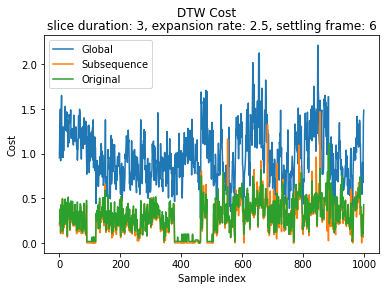

In [10]:
plt.suptitle("DTW Cost")
plt.title(f"slice duration: {SLICE_DURATION}, expansion rate: {EXPANSION_RATE}, settling frame: {SETTLING_FRAME}")
plt.plot(range(len(global_dtw_costs)), global_dtw_costs, label="Global")
plt.plot(range(len(subsequence_dtw_costs)), subsequence_dtw_costs, label="Subsequence")
plt.plot(range(len(original_dtw_costs)), original_dtw_costs, label="Original")
plt.ylabel("Cost")
plt.xlabel("Sample index")
plt.legend()

In [11]:
subsequence_dtw_costs = np.array(subsequence_dtw_costs)
original_dtw_costs = np.array(original_dtw_costs)
diff = np.sqrt(np.sum((subsequence_dtw_costs - original_dtw_costs)**2))
print(diff)

2.70839557340192


In [12]:
err = diff / len(original_dtw_costs)
print(err)